### Importing modules

In [241]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [242]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Data Cleaning Process

---

In [243]:
# This function will print all available information about the dataframe
def print_df_info(df):
    print("Rows and Column:")
    print(df.shape, '\n')
    print('Getting the described function information:')
    print(df.describe(), '\n')
    print('Getting the info() function information:')
    print(df.info())

print_df_info(df)

Rows and Column:
(918, 12) 

Getting the described function information:
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1

- First, let seeing what the rows correlations to are target columns `HeartDisease'.

C:\Users\zachd\AppData\Local\Temp\ipykernel_17108\3431218531.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

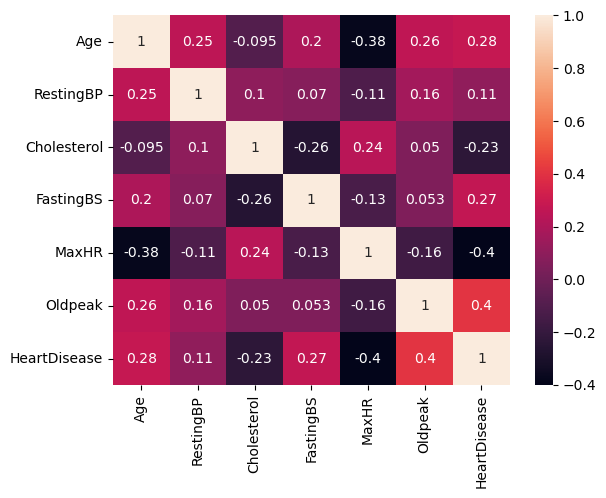

In [244]:
# Using .corr() to create a correlation matrix
corr = df.corr()
# Using seaborn library to create a heat map of df to see the correlations between target and features
sns.heatmap(corr, annot=True)

In the graph above, the columns that has the worst correlation with our target variable would be column `'Cholesterol'`. Even though `MaxHR` has a negative correlation with `HeartDisease`, it has a strong negative correlation with `HeartDieases`, just like how `Oldpeak` has a strong correlation with `HeartDisease`.

- Now I will drop Cholesterol since the column have the worst correlation to the target variable.

In [245]:
# Saving copy of dataframe incase of data leakage
df_copy = df.copy()

# Dropping unnecessary columns
df_copy.drop(columns="Cholesterol", inplace=True)

In [246]:
# viewing dataframe to see if changes were made
df_copy.head()

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,0,Normal,122,N,0.0,Up,0


Now, I will check for duplicated rows in the dataset.

In [247]:
# Checking for duplicate rows
df_copy.duplicated().sum()

0

Next, I will check for any missing values in this dataset.

In [248]:
# Checking for null values in rows and columns
df_copy.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

- To make sure that the data does not contain any outliers or inconsistencies. I will run the following code:

In [249]:
# Printing the max of every column in df
print(f'Max\nThis is the max value: {df_copy.max()}\n')
# Creating the min of every column in df
print(f'Min\nThis is the min value: {df_copy.min()}')

Max
This is the max value: Age                77
Sex                 M
ChestPainType      TA
RestingBP         200
FastingBS           1
RestingECG         ST
MaxHR             202
ExerciseAngina      Y
Oldpeak           6.2
ST_Slope           Up
HeartDisease        1
dtype: object

Min
This is the min value: Age                 28
Sex                  F
ChestPainType      ASY
RestingBP            0
FastingBS            0
RestingECG         LVH
MaxHR               60
ExerciseAngina       N
Oldpeak           -2.6
ST_Slope          Down
HeartDisease         0
dtype: object


Printing the max and min values of df will tell me if we have any rows that are extreme outliers. I concluded that there aren't any rows with extreme outliers.

In [250]:
for i in df_copy.columns:
    print(i)
    print(df[i].value_counts())

Age
54    51
58    42
55    41
56    38
57    38
52    36
51    35
59    35
62    35
53    33
60    32
48    31
61    31
63    30
50    25
46    24
41    24
43    24
64    22
65    21
49    21
47    19
44    19
42    18
45    18
38    16
67    15
39    15
66    13
69    13
40    13
35    11
37    11
68    10
34     7
74     7
70     7
36     6
71     5
32     5
72     4
29     3
75     3
33     2
77     2
76     2
31     2
30     1
28     1
73     1
Name: Age, dtype: int64
Sex
M    725
F    193
Name: Sex, dtype: int64
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64
RestingBP
120    132
130    118
140    107
110     58
150     55
      ... 
185      1
98       1
92       1
113      1
164      1
Name: RestingBP, Length: 67, dtype: int64
FastingBS
0    704
1    214
Name: FastingBS, dtype: int64
RestingECG
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64
MaxHR
150    43
140    41
120    36
130    33
160    25
       ..
63 

- It appears that there are no inconsistencies in the catergorical or numerical data.

## Data Visualization

---

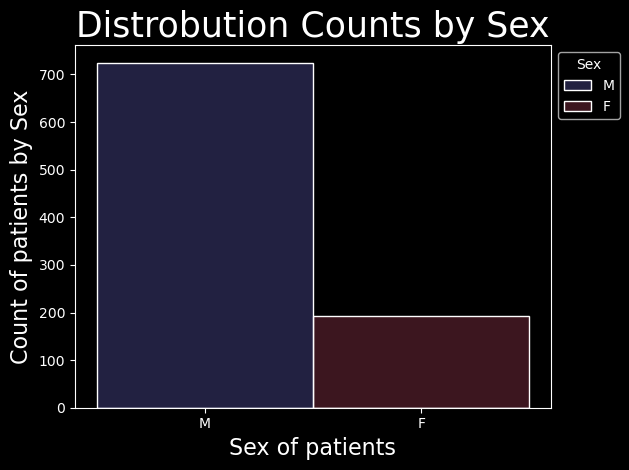

In [251]:
# Using with plt.style.context to format only this histsgram
with plt.style.context(['seaborn-muted', 'dark_background']):
    # Plotting histogram with seaborns histplot
    ax = sns.histplot(data=df_copy, x='Sex', hue='Sex', legend=True, palette='icefire')
    # setting xlabel for histogram
    plt.xlabel('Sex of patients', fontsize=16)
    # setting ylabel for histogram
    plt.ylabel('Count of patients by Sex', fontsize=16)
    # Creating title for histogram
    plt.title('Distrobution Counts by Sex', fontsize=25)
    # Creating legend for histogram
    sns.move_legend(bbox_to_anchor=(1, 1), loc=2, obj=ax)
    plt.tight_layout()

- This graph tells me how many of counts of patients there for posible cardiovascular disease. Males ("M") seems to be the most common patient for heart related diseases.

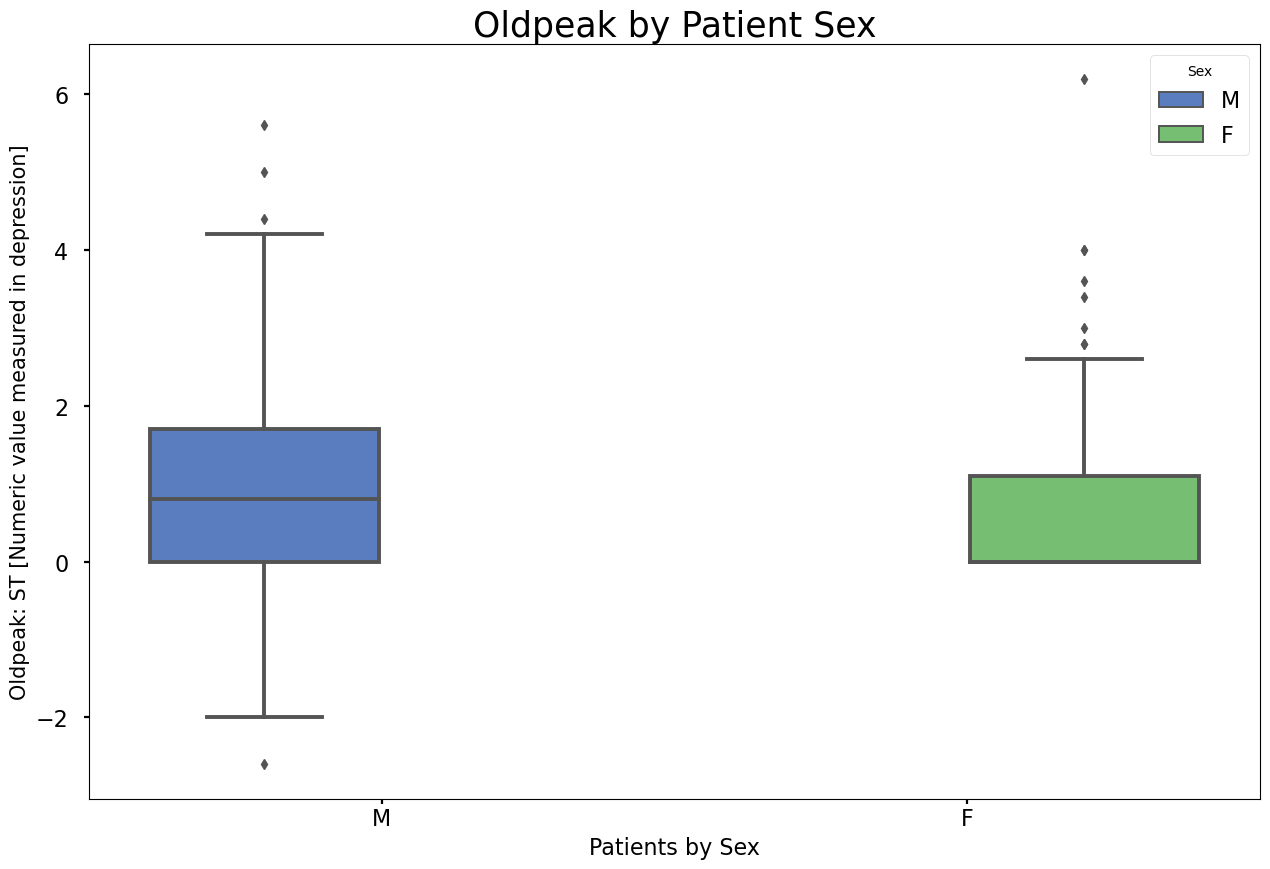

In [252]:
# Setting style for plot
with plt.style.context(['seaborn-muted', 'seaborn-poster']):
    # Creating boxplot with seaborn
    sns.boxplot(data=df_copy, x=df_copy['Sex'], y=df_copy['Oldpeak'], hue=df_copy['Sex'])
    # Setting xticks
    plt.xticks(va='center')
    # Setting xlabel
    plt.xlabel('Patients by Sex', fontsize=16)
    # Setting ylabel
    plt.ylabel('Oldpeak: ST [Numeric value measured in depression]', fontsize=15)
    # Setting title
    plt.title('Oldpeak by Patient Sex', fontsize=25)
    # Setting tightlayout
    plt.tight_layout()

- Looking at this boxplot, it seems that the Male patients tend to have more negative ST scores than female patients. Female patients have more positive outliers than the Male patients at risk.

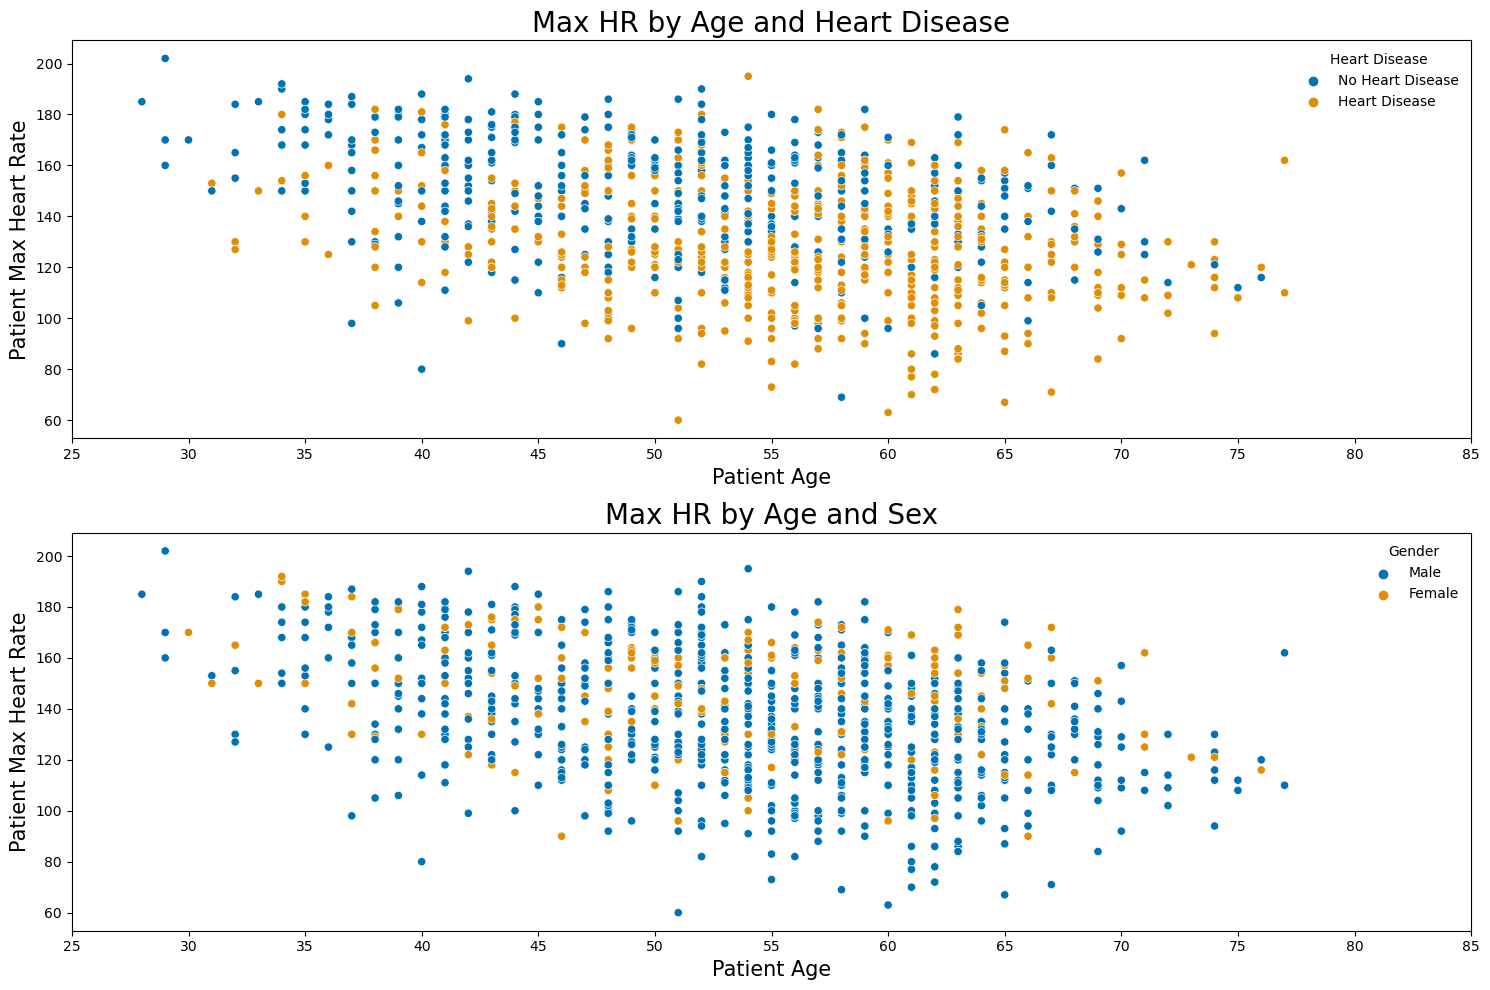

In [253]:
with plt.style.context('seaborn-muted'):
    fig, ax = plt.subplots(2,1, figsize=(15,10))
    sns.scatterplot(data=df_copy, x='Age', y='MaxHR', hue='HeartDisease', ax=ax[0], palette='colorblind')
    ax[0].set_title('Max HR by Age and Heart Disease', fontsize=20)
    ax[0].set_xlabel('Patient Age', fontsize=15)
    ax[0].set_xticks(range(25, 90, 5))
    ax[0].set_ylabel('Patient Max Heart Rate', fontsize=15)
    ax[0].legend(title='Heart Disease', handles=ax[0].get_legend_handles_labels()[0], labels=['No Heart Disease', 'Heart Disease'], frameon=False)
    
    sns.scatterplot(data=df_copy, x='Age', y='MaxHR', hue='Sex', ax=ax[1], palette='colorblind')
    ax[1].set_title('Max HR by Age and Sex', fontsize=20)
    ax[1].set_xlabel('Patient Age', fontsize=15)
    ax[1].set_xticks(range(25, 90, 5))
    ax[1].set_ylabel('Patient Max Heart Rate', fontsize=15)
    ax[1].legend(title='Gender', handles=ax[0].get_legend_handles_labels()[0], labels=['Male', 'Female'], frameon=False)
    
plt.tight_layout()
plt.show();

After reviewing the data dictionary, I started getting curious about what the heart rate of patients by age and gender. The results are the graph above, however, I want to break each graph down to paint a better picture:

**Max HR by Age and Heart Disease:**
In this scatter plot it breaks down patients by age and max heart rate, then shows rather the patient has heart disease or not. What is curious about this plot, is that within range `30-60` with a high heart rate not have heart disease. While range `55-65` with above average heart rate, averages to have heart disease more. However, in this range it seems that heart disease is at an increase rate. Based off of this analysis I recommend that heart rate doesn't play a factor in heart disease in most cases, by maybe age would.

**Max HR by Age and Sex**
In this scatter plot it will be breaking down patients by age and sex, but also group them by gender. In this graph, the patients definitely are prodominatly male in most cases of testing for if high risk for heart disease. Even though male dominates this graph, note, females tend to have high heart rates than males. There could be many factors to play in this subject so I will need to consult someone with more information in the field.

In [254]:
df_plot=df_copy[['Oldpeak', 'MaxHR']]

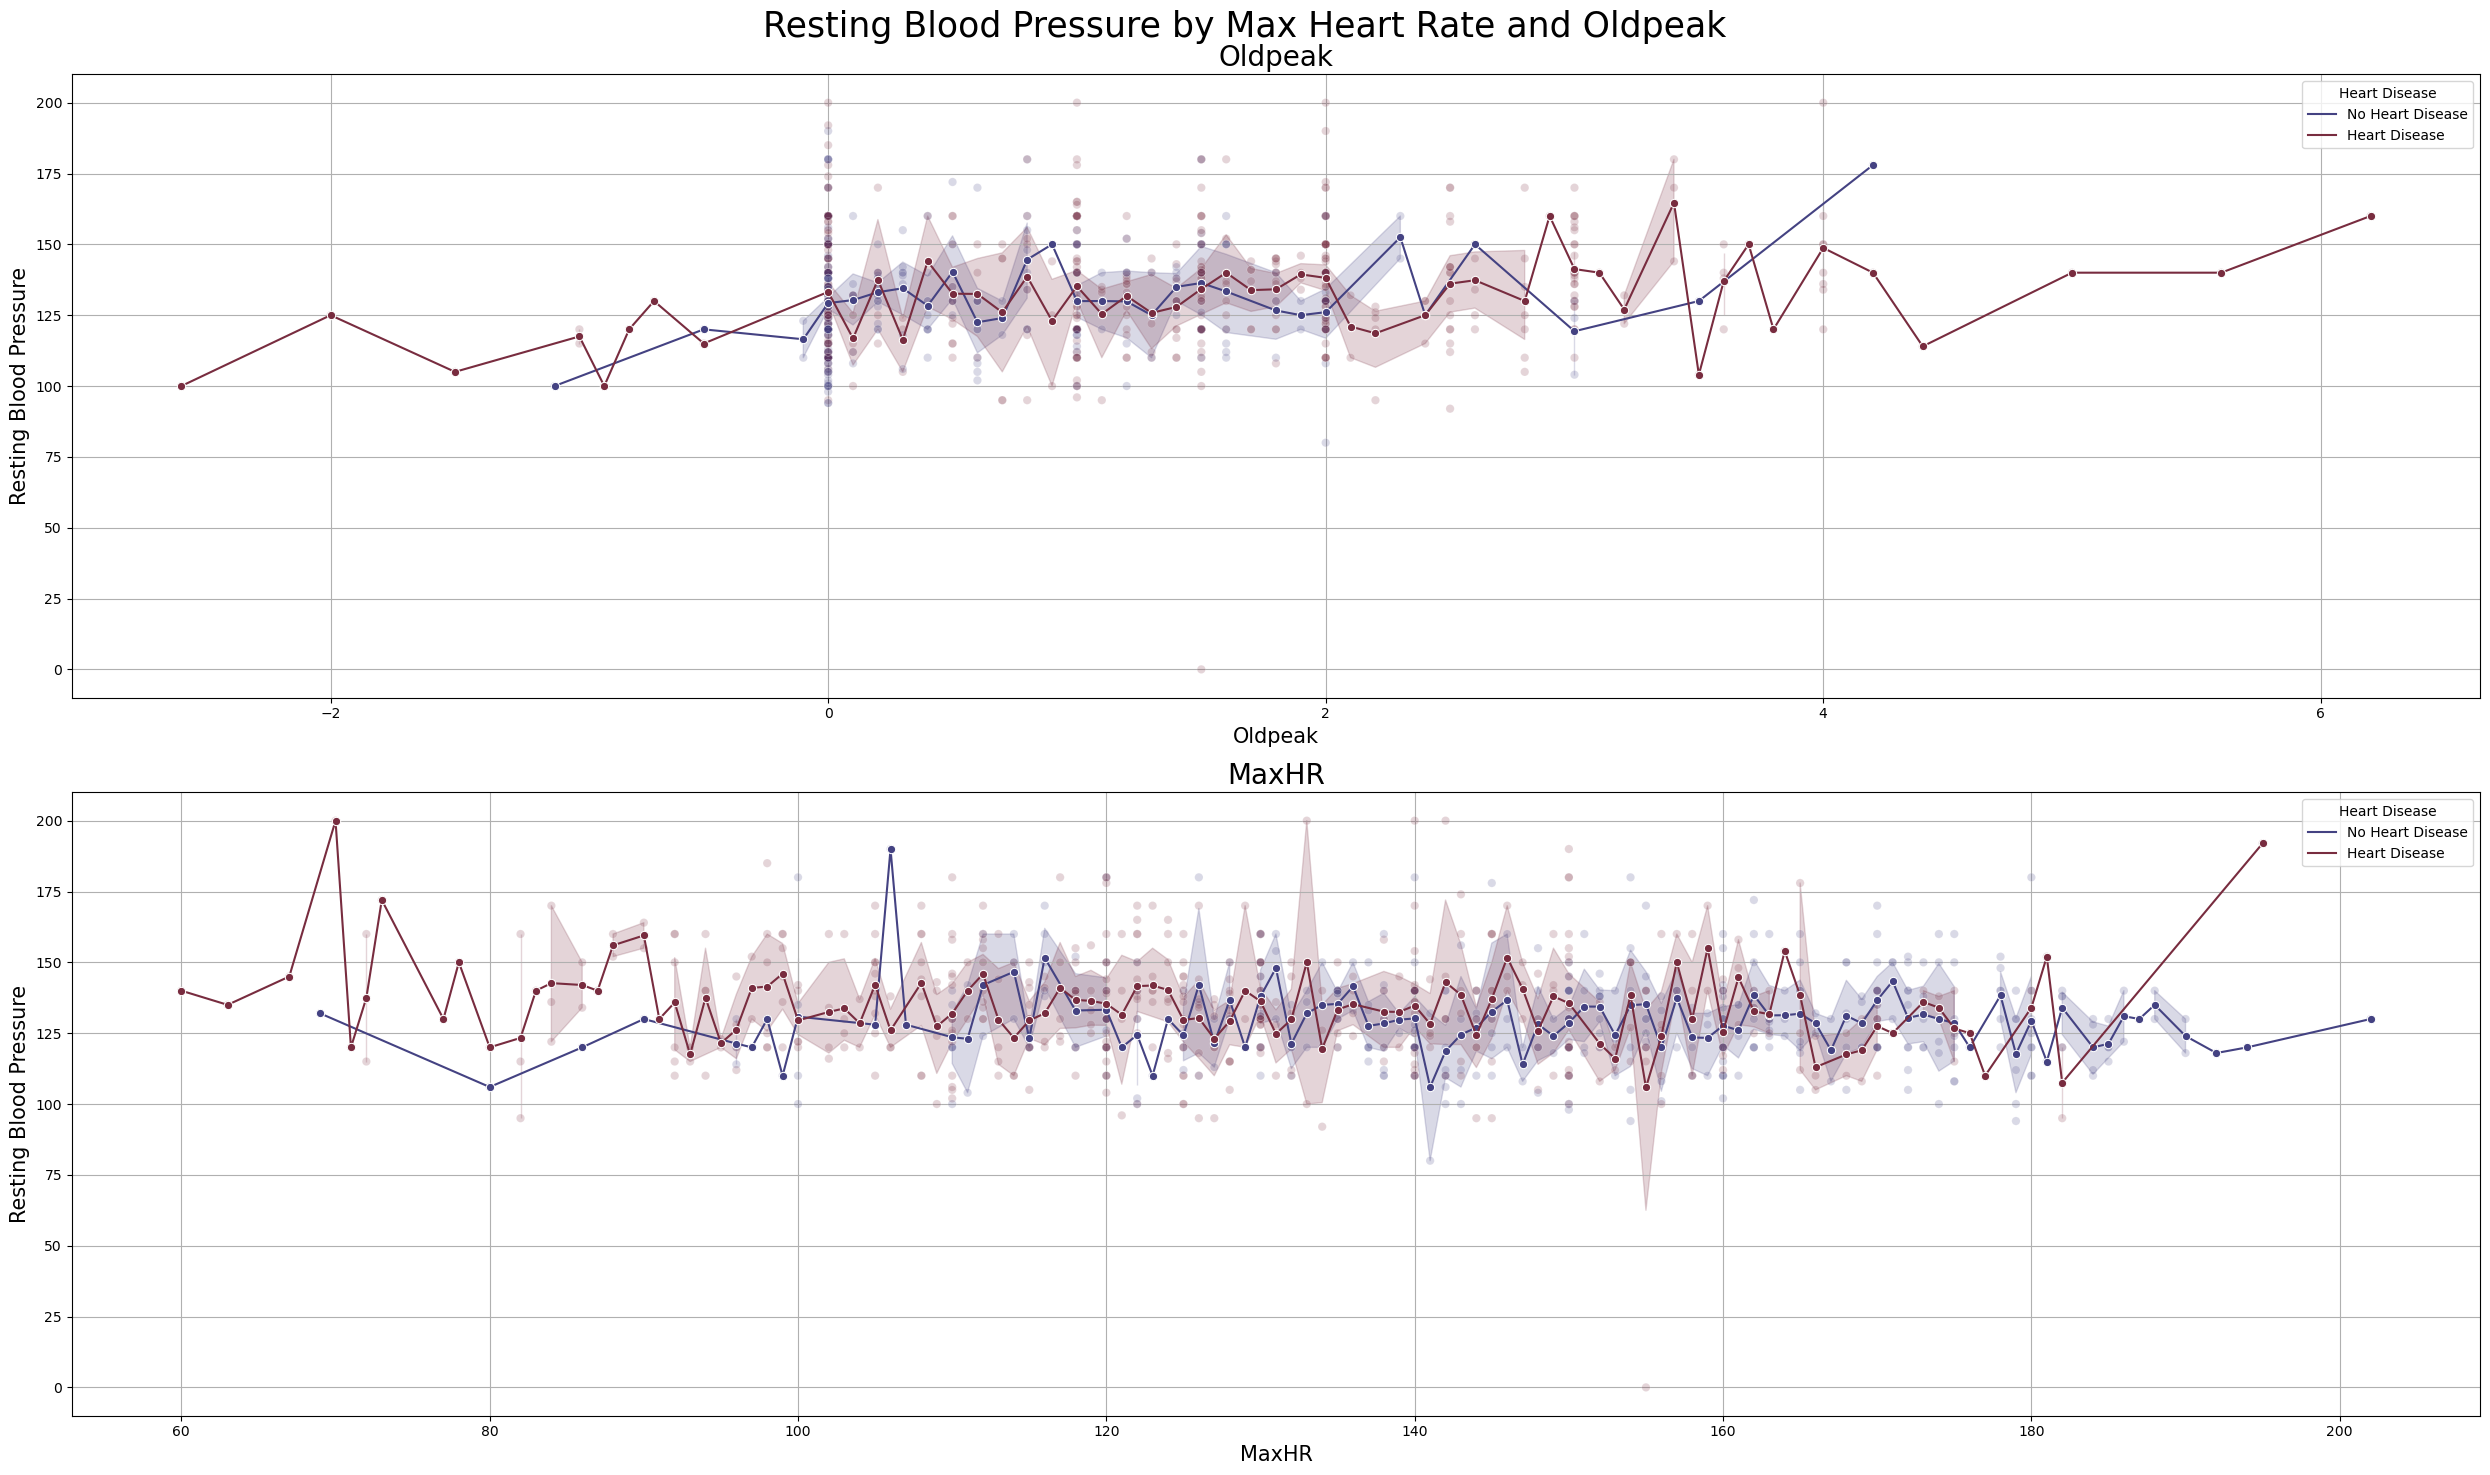

In [255]:
with plt.style.context('seaborn-muted'):
    fig, ax = plt.subplots(2, 1, figsize=(25,15))
    ax = ax.ravel()
    
    for i, col in enumerate(df_plot[1:]):
        sns.lineplot(data=df_copy, x=df_plot[col], y='RestingBP', hue='HeartDisease', ax=ax[i], palette='icefire', zorder=3, linestyle='-', marker='o')
        sns.scatterplot(data=df_copy, x=df_plot[col], y='RestingBP', hue='HeartDisease', ax=ax[i], palette='icefire', zorder=2, alpha=0.2)
        ax[i].set_title(f'{col}', fontsize=20)
        ax[i].set_xlabel(f'{col}', fontsize=15)
        ax[i].set_ylabel('Resting Blood Pressure', fontsize=15)
        ax[i].grid(zorder=0)
        ax[i].legend(handles=ax[i].get_legend_handles_labels()[0], labels=['No Heart Disease', 'Heart Disease'], title='Heart Disease', frameon=True, loc='upper right')
      
plt.suptitle('Resting Blood Pressure by Max Heart Rate and Oldpeak', fontsize=25)  
plt.tight_layout()
plt.show();

The graphs above visualize the differences when comapring `Max Heart Rate` and `Oldpeak` to `Resting Blood Pressure`. I want to break each graph down individualy. 

**Oldpeak**:
The oldpeak column represents the ST score (Numeric value mesured in depression). As we can see above most of the patients ST results were 0, with a resting blood sugar just above 125. It seems the average resting blood sugar level typically stays within `125-150` within the oldpeak values `0-2` on the xaxis. However, between `2-6` on the xaxis, heart disease to fluctuate between `2-4`. Through `4-6` it seems to increase as oldpeak gets higher, while no heart disease stops after 4. It would appear to me that `Oldpeak` doesn't appear to have a huge impact on whether someone is at risk for heart disease or not. One feature that this graph does visualize that if your `Oldpeak` is below `-1` or above `4` you will more than likely obtain heart disease.

**MaxHR**:
The MaxHR column appears to have an average resting blood sugar around `100-160` heart rate. Looking at the scatter points on the graph, it is clear to tell that `120` heart rate is an average heart rate that a patient has. Another feature to note, though 120 heart rate is a good number, some patients within the scatter points have a resting blood sugar over `175`. Having a normal heart rate could not effect a patients blood pressure levels. Also, between `60-100` for `MaxHR` on the xaxis, it seems that patients with high risk of heart disease with lower heart rate tend to hav above average resting blood pressure levels. In my eyes, heart rate comapared to blood pressure does not present with promising results that indicates if a patient with high heart rate or blood pressure level, will or will not be at risk for heart disease.

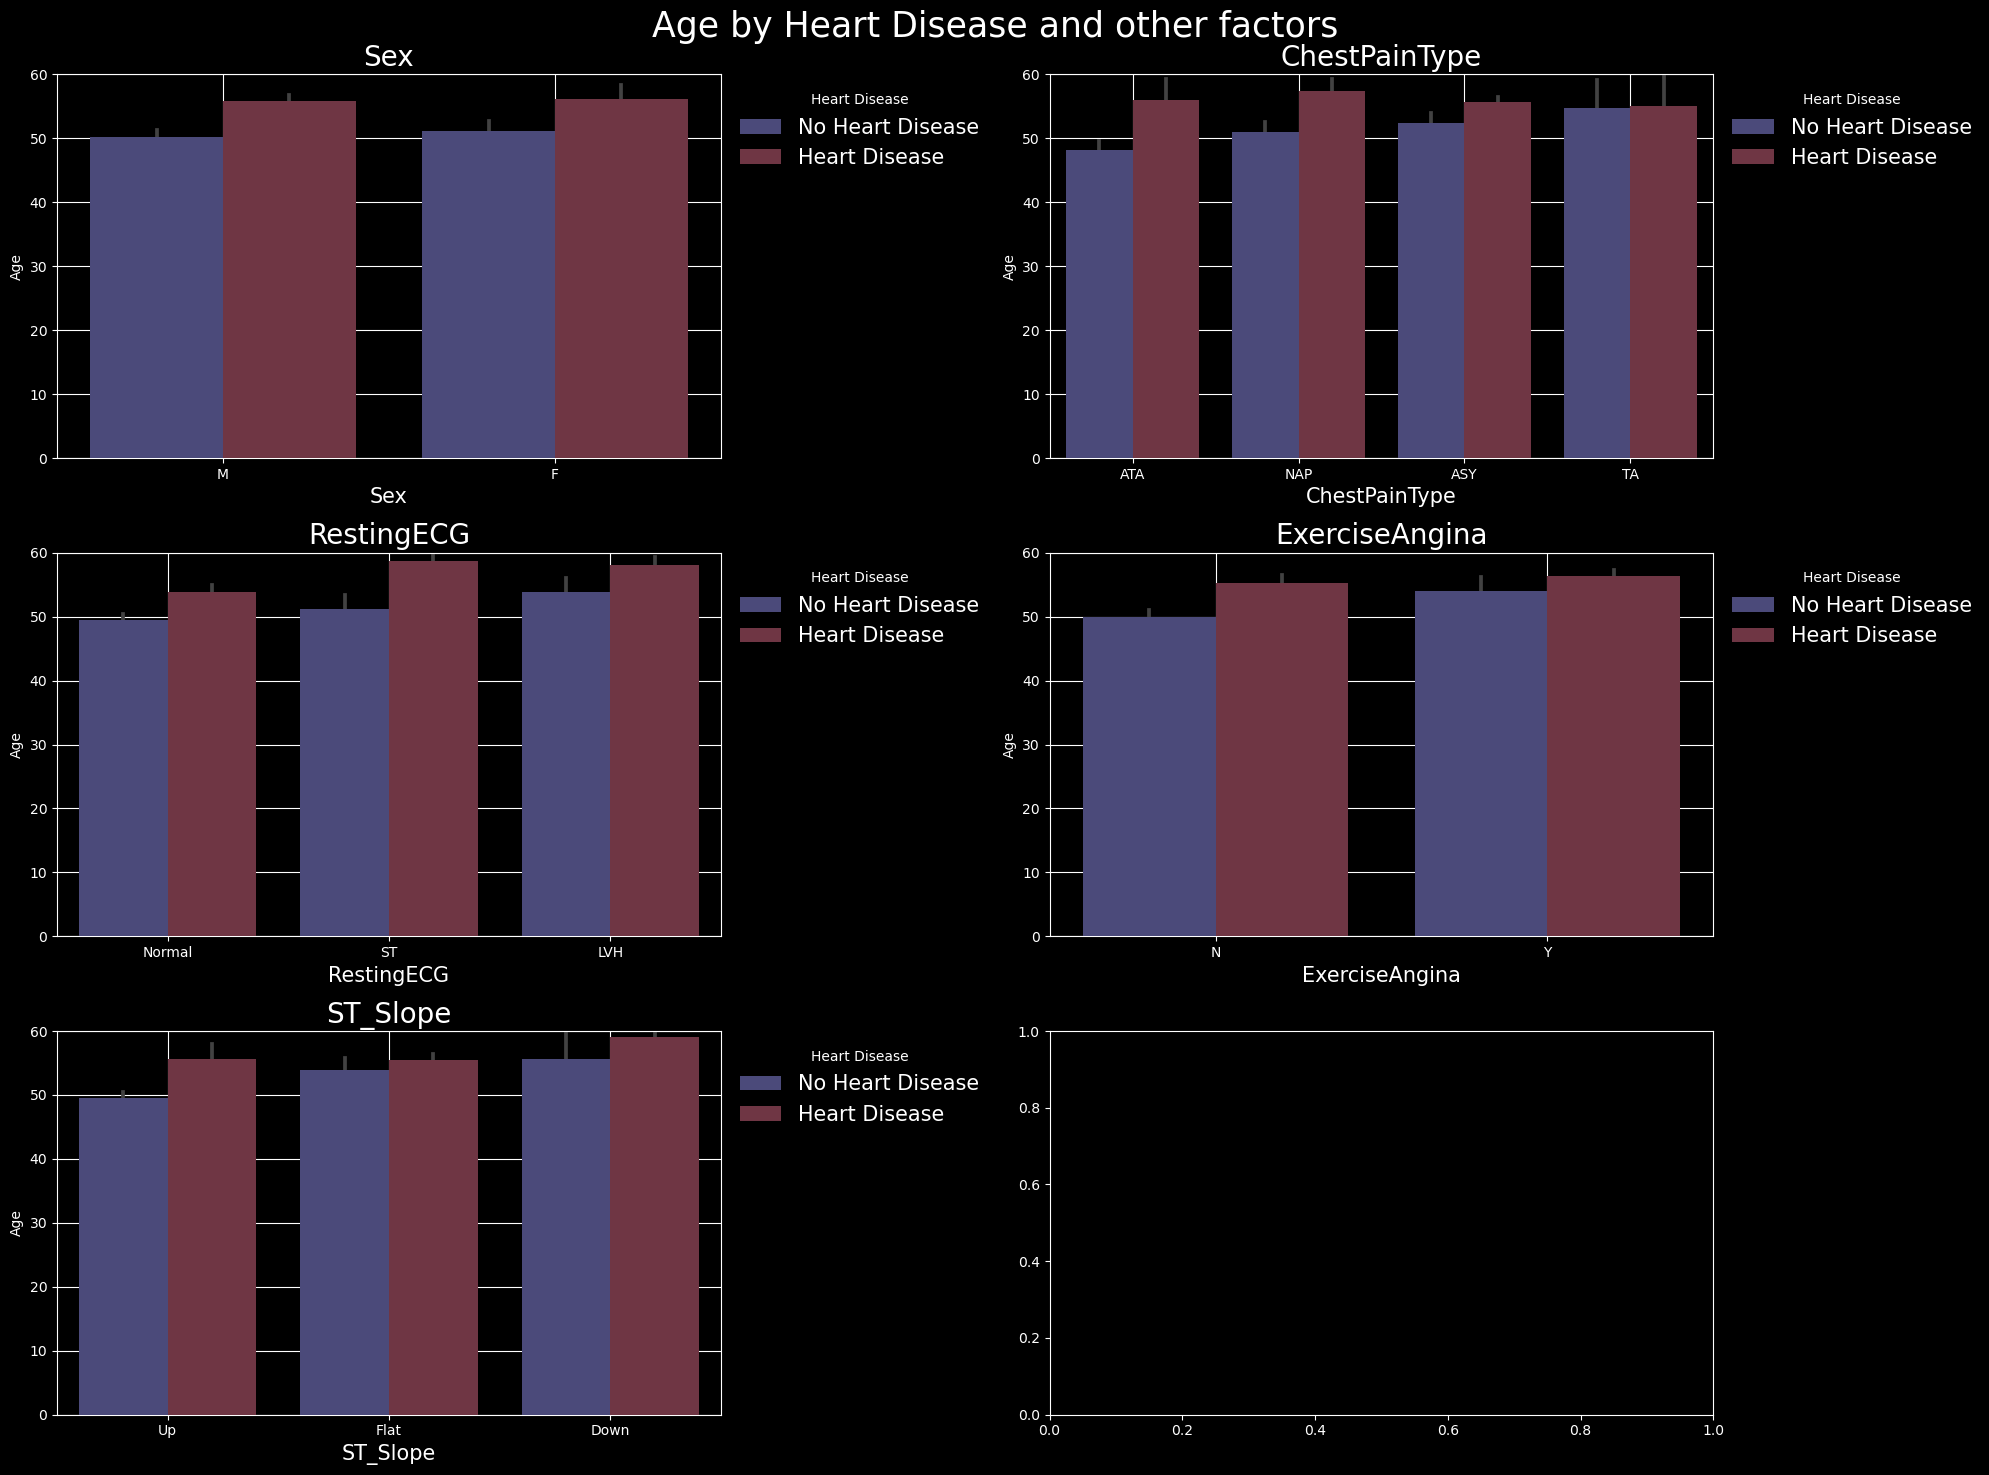

In [256]:
plot_df = df_copy[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]

with plt.style.context(['seaborn-muted', 'dark_background']):
    fig, ax = plt.subplots(3,2, figsize=(20, 15))
    ax = ax.ravel()
    
    for i, col in enumerate(plot_df[1:]):
    
        sns.barplot(data=df_copy, x=col, y='Age', hue='HeartDisease', palette='icefire', ax=ax[i], zorder=3)
        ax[i].set_title(f'{col}', fontsize=20)
        ax[i].set_xlabel(col,fontsize=15)
        ax[i].set_ylim((0,60))
        ax[i].grid(zorder=0, color='white')
        ax[i].legend(handles=ax[i].get_legend_handles_labels()[0], labels=['No Heart Disease', 'Heart Disease'], title='Heart Disease', frameon=False, bbox_to_anchor=(1, 1), fontsize=15)
        
plt.suptitle('Age by Heart Disease and other factors', fontsize=25, c='white')
plt.tight_layout()
plt.show()
    

- I will give a brief explaination of visualization.

For this visualization it compares all categorical columns to age, then graphs if the patient is at risk for heart disease or not. It would appear apparent that most older patients in this data set tend to be at risk for heart disease. Judging by graphs, anyone over the age of 50 tend to be at risk for heart disease then patients under 50. The only visualiztion in these subplots would be in `ChestPainType`, type `TA` almost has the same average for no heart disease and heart disease. This raises the question could pain type `TA` be a general symptom for any related illness or is it a common accurance within human anatomy as age progresses.

--- 

# Modeling

In [257]:
df_copy.select_dtypes(include='object').value_counts(normalize=True)

Sex  ChestPainType  RestingECG  ExerciseAngina  ST_Slope
M    ASY            Normal      Y               Flat        0.118736
     ATA            Normal      N               Up          0.069717
     ASY            Normal      N               Flat        0.059913
                    ST          Y               Flat        0.053377
     NAP            Normal      N               Up          0.050109
                                                              ...   
F    NAP            ST          Y               Flat        0.001089
     TA             LVH         N               Up          0.001089
                    Normal      N               Down        0.001089
M    ATA            LVH         Y               Flat        0.001089
     TA             ST          Y               Flat        0.001089
Length: 95, dtype: float64

In [258]:
# Replacing values in columns with numeric values instead of using OneHotEncoder
df_copy['ChestPainType'].replace({'TA':0, 'ATA':1, 'NAP':2, 'ASY':3}, inplace=True)
df_copy['RestingECG'].replace({'Normal':0, 'ST':1, 'LVH':2}, inplace=True)
df_copy['ST_Slope'].replace({'Up':2, 'Flat':1, 'Down':0}, inplace=True)
df_copy.value_counts(normalize=True)

Age  Sex  ChestPainType  RestingBP  FastingBS  RestingECG  MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease
28   M    1              130        0          2           185    N               0.0      2         0               0.001089
58   M    2              130        0          1           140    N               0.0      1         1               0.001089
                         137        0          1           124    Y               1.4      1         1               0.001089
                         140        0          0           160    N               0.0      2         0               0.001089
                                    1          2           165    N               0.0      2         0               0.001089
                                                                                                                       ...   
50   M    3              140        0          1           140    Y               5.0      1         1               0.001089
    

The reason for `Ordinal Endoing` this data manually is to ensure that we have less of a chance to have data leakage later. This is during the `OneHotEncoder` preprocessing later in the maching learning section below. Also, note that I will be `OneHotEncoding` columns: `'Sex'` and `'ExerciseAngina'`.

In [259]:
# Creating variable for features by dropping target variable
X = df_copy.drop('HeartDisease', axis=1)
# Creating variable for target variable
y = df_copy['HeartDisease']
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [260]:
num_tup = (StandardScaler(), make_column_selector(dtype_include='number'))
cat_tup = (OneHotEncoder(handle_unknown='ignore', sparse=False), make_column_selector(dtype_include='object'))


preprocessor = make_column_transformer(num_tup, cat_tup)

In [261]:
# Creating a fuction to evaluate the models performance on the training and testing data.
# This function will also print out the classification report for both the training and testing data.
# This function will also plot the confusion matrix for both the training and testing data.
def evaluate(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    print(f'Training Score: {round(model.score(X_train, y_train), 2)}')
    print(f'Testing Score: {round(model.score(X_test, y_test),2)}')
    
    train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print(f'Test Classification Report: \n{classification_report(y_test, y_pred)}')
    print(f'Training Classification Report: \n{classification_report(y_train, train_pred)}')\
    
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['No Heart Disease', 'Heart Disease'], cmap='Blues_r', ax=ax[0], normalize='true')
    ax[0].set_title('Test Confusion Matrix', fontsize=20)
    ConfusionMatrixDisplay.from_predictions(y_train, train_pred, display_labels=['No Heart Disease', 'Heart Disease'], cmap='Blues_r', ax=ax[1], normalize='true')
    ax[1].set_title('Train Confusion Matrix', fontsize=20)

In [262]:
# Creating custom function to create a pipeline and gridsearchcv for each model specified and evaluate the model
# This function will also return the best estimator for each model and fit the model to the training data
def model(model, param, X_train, X_test, y_train, y_test, preprocess, PCA=None, x=None, y=None):
    pipeline = make_pipeline(preprocess, model)
    gs = GridSearchCV(pipeline, param_grid=param)
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    best.fit(X_train, y_train)
    evaluate(best, X_train, X_test, y_train, y_test)
    return best

Training Score: 0.88
Testing Score: 0.84
Test Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.90      0.83        98
           1       0.91      0.80      0.85       132

    accuracy                           0.84       230
   macro avg       0.84      0.85      0.84       230
weighted avg       0.85      0.84      0.84       230

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       312
           1       0.86      0.93      0.89       376

    accuracy                           0.88       688
   macro avg       0.88      0.87      0.88       688
weighted avg       0.88      0.88      0.88       688



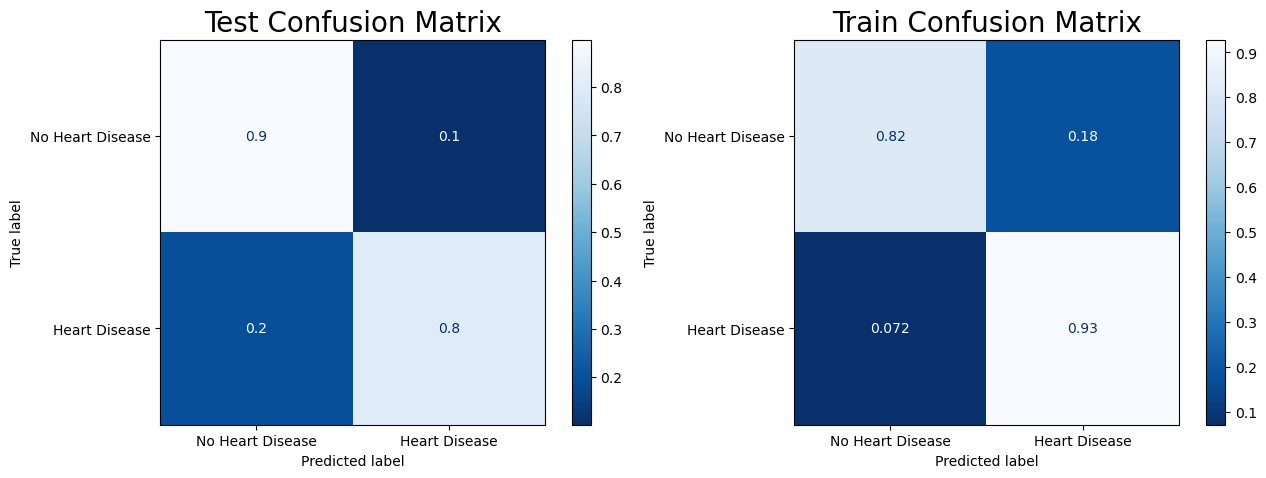

In [263]:
# Creating a pipeline to scale the data and run a decision tree
dc_tree = model(DecisionTreeClassifier(random_state=42),
                {'decisiontreeclassifier__criterion':['gini', 'entropy', 'log_loss'],'decisiontreeclassifier__max_depth':range(1,10), 'decisiontreeclassifier__splitter':['best', 'random']}, 
                X_train, 
                X_test, 
                y_train, 
                y_test, 
                preprocess=preprocessor)

c:\Users\zachd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\zachd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\zachd\anaconda3\envs\dojo-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training Score: 0.86
Testing Score: 0.86
Test Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        98
           1       0.90      0.85      0.88       132

    accuracy                           0.86       230
   macro avg       0.86      0.86      0.86       230
weighted avg       0.86      0.86      0.86       230

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       312
           1       0.86      0.88      0.87       376

    accuracy                           0.86       688
   macro avg       0.86      0.85      0.85       688
weighted avg       0.86      0.86      0.86       688



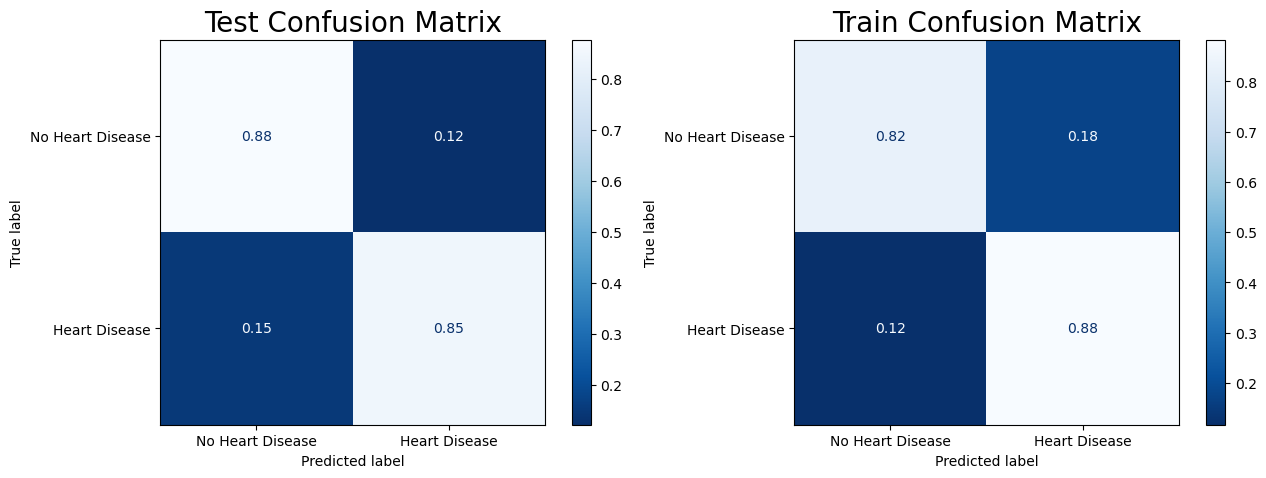

In [270]:
# Creating a pipeline with a StandardScaler and a Logistic Regression model
log_reg = model(LogisticRegression(random_state=42), 
                {'logisticregression__C':range(1, 10), 'logisticregression__penalty':['l1', 'l2'], 'logisticregression__solver':['liblinear', 'saga']}, 
                X_train, 
                X_test, 
                y_train, 
                y_test, 
                preprocess=preprocessor)

Training Score: 0.89
Testing Score: 0.86
Test Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.89      0.84        98
           1       0.91      0.84      0.87       132

    accuracy                           0.86       230
   macro avg       0.86      0.86      0.86       230
weighted avg       0.87      0.86      0.86       230

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       312
           1       0.88      0.92      0.90       376

    accuracy                           0.89       688
   macro avg       0.89      0.88      0.89       688
weighted avg       0.89      0.89      0.89       688



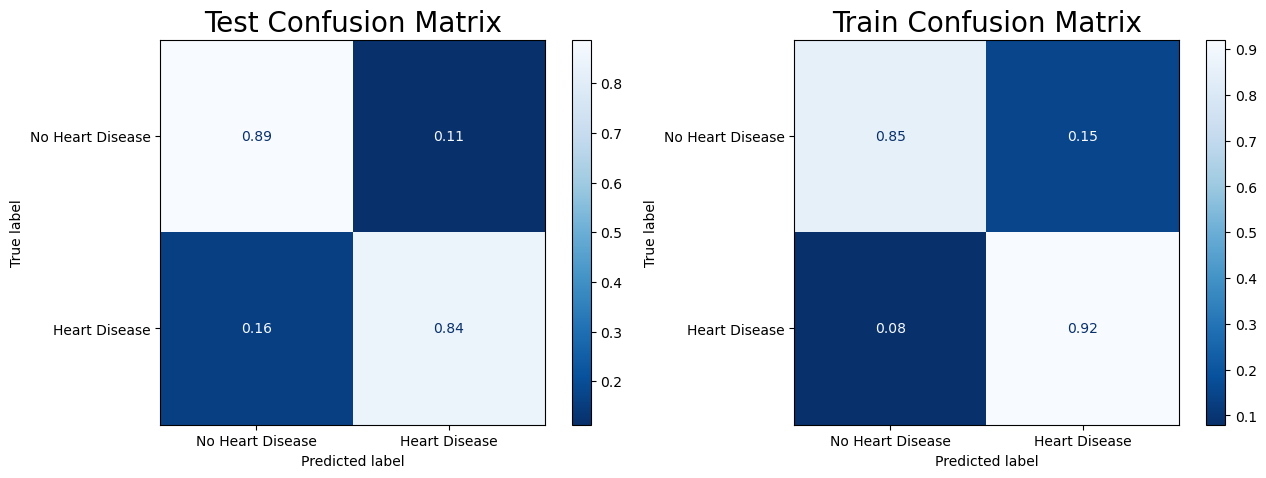

In [265]:
# Creating a pipeline for the Random Forest Classifier
reg_for = model(RandomForestClassifier(random_state=42), 
                {'randomforestclassifier__n_estimators':range(1, 10), 'randomforestclassifier__criterion':['gini', 'entropy'], 'randomforestclassifier__max_depth':range(1,10)}, 
                X_train, 
                X_test, 
                y_train, 
                y_test, 
                preprocess=preprocessor)

Training Score: 1.0
Testing Score: 0.86
Test Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        98
           1       0.90      0.85      0.87       132

    accuracy                           0.86       230
   macro avg       0.85      0.86      0.85       230
weighted avg       0.86      0.86      0.86       230

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       1.00      1.00      1.00       376

    accuracy                           1.00       688
   macro avg       1.00      1.00      1.00       688
weighted avg       1.00      1.00      1.00       688



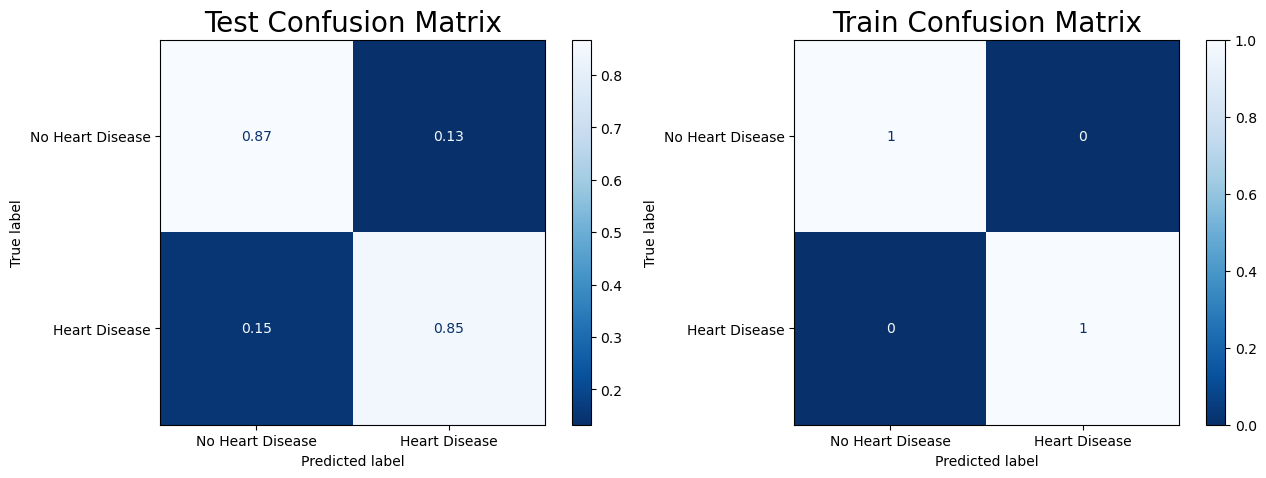

In [266]:
# Creating a knn model pipeline
knn = model(KNeighborsClassifier(), 
            {'kneighborsclassifier__n_neighbors':range(1, 10), 'kneighborsclassifier__weights':['uniform', 'distance'], 'kneighborsclassifier__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}, 
            X_train, 
            X_test, 
            y_train, 
            y_test, 
            preprocess=preprocessor)

In [281]:
# Creating a pipeline for PCA
pca = make_pipeline(preprocessor, PCA(n_components=0.95))
pca.fit(X_train, y_train)

print('Training Score: ', pca.score(X_train, y_train))
print('Testing Score: ', pca.score(X_test, y_test))

Training Score:  -12.359293044026767
Testing Score:  -12.81074623558721


### DecisionTreeClassifier

Testing Score: 0.84

Test Classification Report: 

              precision    recall  f1-score   support

           0       0.78      0.87      0.82        98
           1       0.89      0.82      0.85       132
### LogisticRegression

Testing Score: 0.86

Test Classification Report: 

              precision    recall  f1-score   support

           0       0.81      0.88      0.84        98
           1       0.90      0.85      0.88       132
### RandomForestClassifier

Testing Score: 0.86

Test Classification Report: 

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        98
           1       0.89      0.86      0.88       132
### KNN

Testing Score: 0.87

Test Classification Report: 

              precision    recall  f1-score   support

           0       0.81      0.89      0.85        98
           1       0.91      0.85      0.88       132
### PCA with RandomForestClassifier

Testing Score: 0.84

Test Classification Report: 

              precision    recall  f1-score   support

           0       0.79      0.87      0.83        98
           1       0.89      0.83      0.86       132

# Final Model Selection:

I will use the RandomForestClassifier model for this project. If judged by test scores alone, the KNN model would be the choice of others. However, looking back at the confusion matrix plots, the RandomForestClassifier has a decrease in false negatives but an increase in false positives. Later on in time, I felt like this would be easier to manage. In order to improve the model's accuracy, I wanted to adjust the false negative/false positive ratio or use a boosting library. Hence, I selected this model.